In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from functools import partial

In [3]:
N1_liste=[50,70,80,90,95,96,97,98,99,100,101,102,103,104]
T45_liste=[350,500,600,650,675,700,715,730,745,760,775,790,805,820,835,850,865,880,900,910,920,930,940,950,960,962]
Y=[]
for N1 in N1_liste:
    for T45 in T45_liste:
        Y.append([N1,T45])
couple=pd.DataFrame(Y,columns=["N1","T45"])
couple1=couple.copy()
df=pd.read_csv("data_constrained_BG_50Kses_5Kpoint_centrée.csv")
endo=pd.read_csv("Endofluage.csv", sep=";")["Endofluage"]
df["Endoflu"]=df.iloc[:,1:].dot(endo.to_numpy())

df=df[df.f_session<500000]
df1=df.copy()
m=len(df1)
scaler = StandardScaler() 
#y=df["target"]
y=df["Endoflu"]


#X1=df1.iloc[:,6:-2]
X1 = df1.iloc[:,:-1]
X1=pd.DataFrame(scaler.fit_transform(X1))
X1.iloc[:,0]=1


#Troncature
#df["Endoflu"]=round(df["Endoflu"],2)

df.head()

,f_session,theta_N1_50_T45_350,theta_N1_50_T45_500,theta_N1_50_T45_600,theta_N1_50_T45_650,theta_N1_50_T45_675,theta_N1_50_T45_700,theta_N1_50_T45_715,theta_N1_50_T45_730,theta_N1_50_T45_745,...,theta_N1_104_T45_880,theta_N1_104_T45_900,theta_N1_104_T45_910,theta_N1_104_T45_920,theta_N1_104_T45_930,theta_N1_104_T45_940,theta_N1_104_T45_950,theta_N1_104_T45_960,theta_N1_104_T45_962,Endoflu
0,27078,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1359.811658
1,27207,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1136.645026
2,27327,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1413.424385
3,27659,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1547.955725
4,27671,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,0,1246.405420


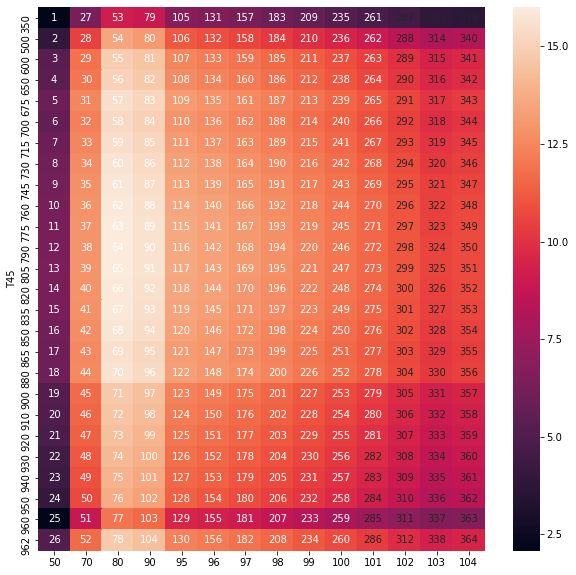

In [4]:
#Feature importance
dfsum=df1.iloc[:,1:-1].sum(axis=0)
couple["init_freq"]=dfsum.to_numpy()

table_freq=np.zeros((len(T45_liste),len(N1_liste)))
for i,v in enumerate(T45_liste):
    for j,w in enumerate(N1_liste):
        table_freq[i,j]=couple[(couple["T45"]==v)&(couple["N1"]==w)]["init_freq"]
table_freq=pd.DataFrame(table_freq,columns=list(map(lambda x:str(x),N1_liste)))
table_freq["T45"]=pd.Series(T45_liste)
table_freq=table_freq.set_index("T45")

#Theta index
table_index=pd.DataFrame(np.arange(1,365,1).reshape(14, 26).T,columns=list(map(lambda x:str(x),N1_liste)))
table_index["T4"]=pd.Series(T45_liste)
table_index=table_index.set_index("T4")

plt.figure(figsize=(10,10))
sns.heatmap(table_index,annot=True,cmap=None,fmt="d",cbar=None)
sns.heatmap(np.log(table_freq[table_freq>1]))

In [5]:
def lag_h(theta,period):
    theta1=theta.copy()
    theta1=theta1.shift(periods=period,axis='columns')
    if period==1:
        theta1.iloc[:,0]=0.0
    elif period==-1:
        theta1.iloc[:,-1]=0.0
    return theta1

def lag_v(theta,period):
    theta1=theta.copy()
    theta1=theta1.shift(periods=period)
    if period==1:
        theta1.iloc[0,:]=0.0
    elif period==-1:
        theta1.iloc[-1,:]=0.0
    return theta1

def plot_surface(couple):
    fig = plt.figure(figsize=(15,5))
    ax0 = fig.add_subplot(111, projection='3d')
    ax0.set_xlabel('$N1$')
    ax0.set_ylabel('$T45$')
    ax0.set_title("Table Endofluage")
    ax0.plot_trisurf(couple["N1"], couple["T45"], couple["result"])
    
def heaviside(x):
    result=np.where(x<0,0,1)
    return result

def table_theta(theta):
    theta=pd.DataFrame(theta.reshape(14, 26)).T
    return theta

def convert_theta(theta):
    M=scaler.mean_
    s=scaler.scale_
    thetaprim=theta/s
    return thetaprim

## Optimisation Scipy.optimize

In [14]:
def objective(theta): 
    #Objective function
    res = 1/(2*m)*((y-X1.dot(theta))**2).sum()
    
    #Callback
    cs1=heaviside(constraint1(theta))
    cs2=heaviside(constraint2(theta))
    cs3=heaviside(constraint3(theta))
    cs4=heaviside(constraint4(theta))
    taux=(cs1+cs2+cs3+cs4)/len(css)*100
    theta2=convert_theta(theta)
    global iteration
    if iteration%10 == 0:
        print ("Iter:", str(iteration), "Theta:",theta2[1:5].T,"\n","MSE:",round(res,8),"\n","CSS_rate:",np.round(taux,1),"%","\n")
    iteration += 1

    return res

#Constraints
def constraint1(theta):
    theta2=convert_theta(theta)
    return theta2[70]-1000*theta2[55]

def constraint2(theta):
    theta2=convert_theta(theta)
    return theta2[96]-1000*theta2[81]

def constraint3(theta):
    theta2=convert_theta(theta)
    return theta2[148]-10*theta2[70]

def constraint4(theta):
    theta2=convert_theta(theta)
    return theta2[137]-10*theta2[59]

css=[]
css.append({"type":'ineq','fun': constraint1})
css.append({"type":'ineq','fun': constraint2})
css.append({"type":'ineq','fun': constraint3})
css.append({"type":'ineq','fun': constraint4})

#Bounds
b=(0,10000000)
b2=(-10000000000,100000000000)
bnds=[]
for i in range(365):
    if i==0:
        bnds.append(b2)
    else:
        bnds.append(b)
        
    
bnds=tuple(bnds)


#Callbacks
def callbackF(theta):
    return MSE_liste.append(1/(2*m)*((y-X1.dot(theta))**2).sum())

In [15]:
theta0=np.ones(365)

MSE_liste=[]
iteration=0
sol=minimize(objective, theta0,method='SLSQP',   #'trust-constr SLSQP'
             bounds=bnds,
             constraints=css)#,
             #callback=callbackF)
             #options={'disp': True, 'ftol':0.05, 'maxfev':100000}) #options={"maxiter":5000})

theta=convert_theta(sol.x)[1:]
COST=sol.fun

Iter: 0 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.7081 
 CSS_rate: 0.0 % 

Iter: 10 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810002 
 CSS_rate: 0.0 % 

Iter: 20 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810001 
 CSS_rate: 0.0 % 

Iter: 30 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810001 
 CSS_rate: 0.0 % 

Iter: 40 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810001 
 CSS_rate: 0.0 % 

Iter: 50 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810002 
 CSS_rate: 0.0 % 

Iter: 60 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810003 
 CSS_rate: 0.0 % 

Iter: 70 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70810002 
 CSS_rate: 0.0 % 

Iter: 80 Theta: [ 1.         31.63859986 15.57401846 15.2474857 ] 
 MSE: 771849.70809983 
 CSS_rate: 0.0 % 

Iter: 90 Theta: [ 1.    

Iter: 720 Theta: [1.00000000e+00 2.47176561e-01 6.57044087e-14 1.22694612e+01] 
 MSE: 28.12876595 
 CSS_rate: 75.0 % 

Iter: 730 Theta: [1.00000000e+00 2.47176561e-01 6.57044087e-14 1.22694612e+01] 
 MSE: 28.12876596 
 CSS_rate: 75.0 % 

Iter: 740 Theta: [1.         0.         0.         0.27613592] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 750 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 760 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 770 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 780 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 790 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 800 Theta: [1.         0.         0.         0.27613569] 
 MSE: 0.27794027 
 CSS_rate: 75.0 % 

Iter: 810 Theta: [1.         0.         0.      

Iter: 1470 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1480 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1490 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1500 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1510 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1520 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1530 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1540 Theta: [1.00000000e+00 5.74152266e-03 0.00000000e+00 5.29003428e-17] 
 MSE: 0.00075633 
 CSS_rate: 100.0 % 

Iter: 1550 Theta: [1.00000000e+00 5.7415

Iter: 2160 Theta: [1.00000000e+00 3.87619817e-16 4.01159897e-04 4.95948470e-17] 
 MSE: 0.00010078 
 CSS_rate: 100.0 % 

Iter: 2170 Theta: [1.00000000e+00 3.87619817e-16 4.01159897e-04 4.95948470e-17] 
 MSE: 0.00010078 
 CSS_rate: 100.0 % 

Iter: 2180 Theta: [1.00000000e+00 3.87619817e-16 4.01159897e-04 4.95948470e-17] 
 MSE: 0.00010078 
 CSS_rate: 100.0 % 

Iter: 2190 Theta: [1.00000000e+00 3.87619817e-16 4.01159897e-04 4.95948470e-17] 
 MSE: 0.00010078 
 CSS_rate: 100.0 % 

Iter: 2200 Theta: [1.00000000e+00 3.87619817e-16 4.01159897e-04 4.95948470e-17] 
 MSE: 0.00010078 
 CSS_rate: 100.0 % 

Iter: 2210 Theta: [1.00000000e+00 0.00000000e+00 6.63483847e-05 0.00000000e+00] 
 MSE: 1.339e-05 
 CSS_rate: 75.0 % 

Iter: 2220 Theta: [1.00000000e+00 0.00000000e+00 6.63483847e-05 0.00000000e+00] 
 MSE: 1.339e-05 
 CSS_rate: 75.0 % 

Iter: 2230 Theta: [1.00000000e+00 0.00000000e+00 6.63483847e-05 0.00000000e+00] 
 MSE: 1.339e-05 
 CSS_rate: 75.0 % 

Iter: 2240 Theta: [1.00000000e+00 0.00000000e+

Iter: 2860 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2870 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2880 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2890 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2900 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2910 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2920 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2930 Theta: [1.00000000e+00 5.09155446e-17 0.00000000e+00 0.00000000e+00] 
 MSE: 1.56e-06 
 CSS_rate: 100.0 % 

Iter: 2940 Theta: [1.00000000e+00 4.71451876e-07 0.00000

In [350]:
#fig, axe=plt.subplots(1,1,figsize=(20,5), sharey=True) 
#plt.scatter(list(range(len(MSE_liste[1:]))), MSE_liste[1:])
#sol

Text(0.5, 1, 'Horizontalement: N1')

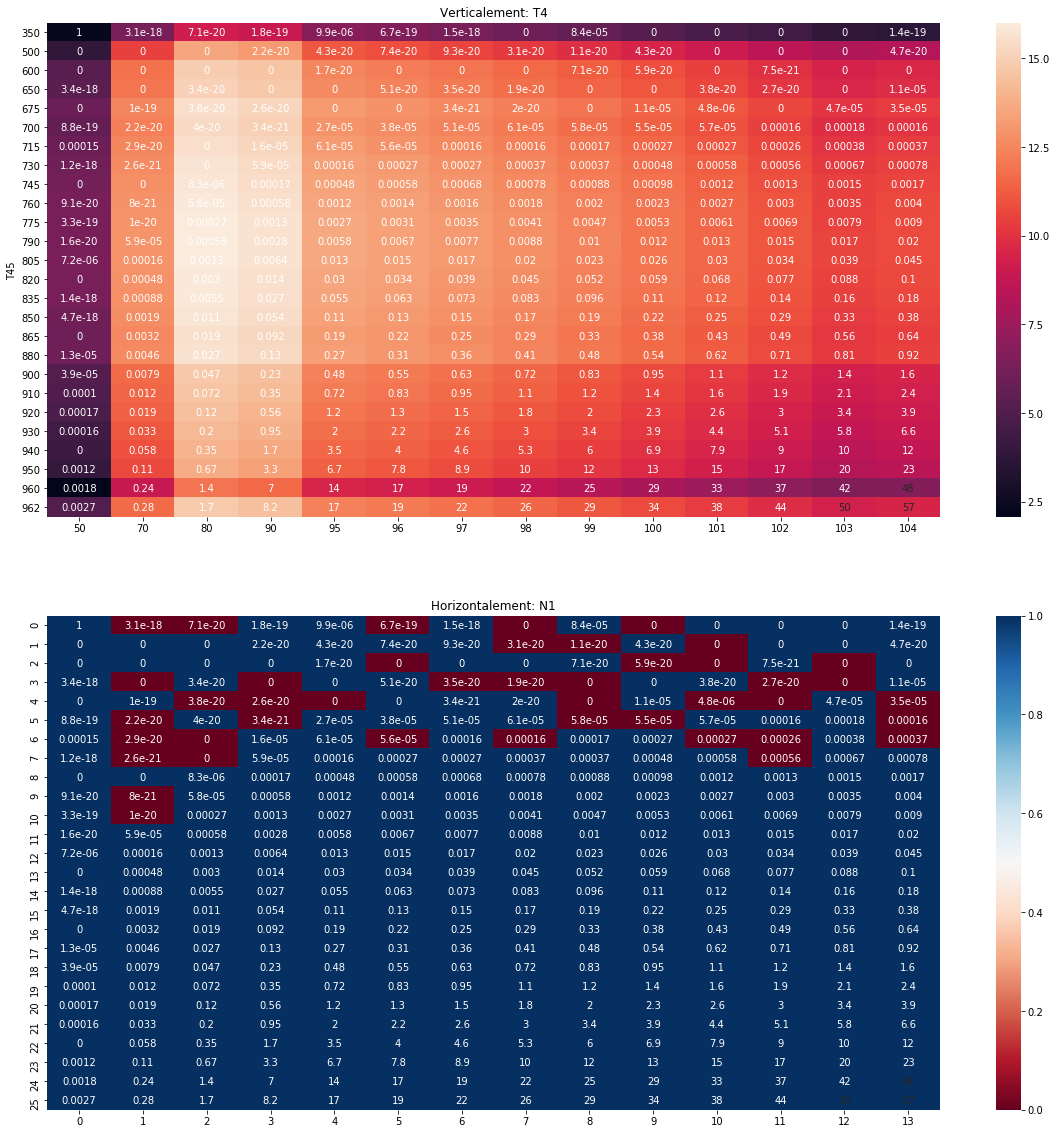

In [16]:
table_endo=table_t
table_endonull=table_endo[table_endo==0]*-1

fig, axe=plt.subplots(3,1,figsize=(20,20), sharex=False)

sns.heatmap(table_endo,annot=True,cmap=None,cbar=None,ax=axe[0])
sns.heatmap(np.log(table_freq[table_freq>1]),cmap=None,ax=axe[0])

sns.heatmap(table_endo,annot=True,cmap=None,cbar=None,ax=axe[1])
sns.heatmap(heaviside(table_endo-lag_v(table_endo,1)),ax=axe[1],cmap="RdBu")

sns.heatmap(table_endo,annot=True,cmap=None,cbar=None,ax=axe[2])
sns.heatmap(heaviside(table_endo-lag_h(table_endo,1)),ax=axe[2],cmap="RdBu")

axe[0].set_title("Distribution")
axe[1].set_title("Verticalement: T4")
axe[2].set_title("Horizontalement: N1")

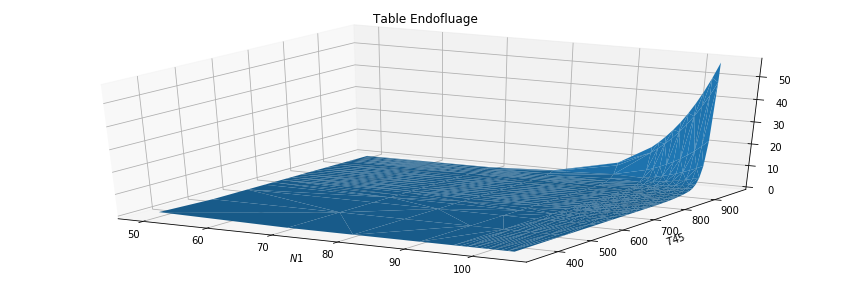

In [17]:
N1_liste=[50,70,80,90,95,96,97,98,99,100,101,102,103,104]
T45_liste=[350,500,600,650,675,700,715,730,745,760,775,790,805,820,835,850,865,880,900,910,920,930,940,950,960,962]
Y=[]
for N1 in N1_liste:
    for T45 in T45_liste:
        Y.append([N1,T45])
couple=pd.DataFrame(Y,columns=["N1","T45"])
couple1=couple.copy()
couple["result"]=pd.Series(theta)   
plot_surface(couple)

### Regression linéaire sans contrainte

In [10]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=5000)
Model = LinearRegression(fit_intercept=False)
Model=Ridge(alpha=0.1, random_state=99,fit_intercept=False) #positive=True,selection='random',max_iter=1000,alpha=0.0001,

Model = Model.fit(X_train, y_train)

ypred_train=Model.predict(X_train).reshape(-1,1)
ypred_test=Model.predict(X_test).reshape(-1,1)

r2_train=Model.score(X_train,y_train)
r2_test=Model.score(X_test,y_test)
MSE_train=mean_squared_error(y_train,ypred_train)
MSE_test=mean_squared_error(y_test,ypred_test)

print("r2_train: ",round(r2_train,2),"\n","r2_test: ",round(r2_test,2),"\n","\n","MSE_train: ",MSE_train,"\n","MSE_test: ",MSE_test)
theta=convert_theta(Model.coef_)[1:]

r2_train:  1.0 
 r2_test:  1.0 
 
 MSE_train:  9.689540468237596e-06 
 MSE_test:  9.865969859052979e-06


Text(0.5, 1, 'Horizontalement: N1')

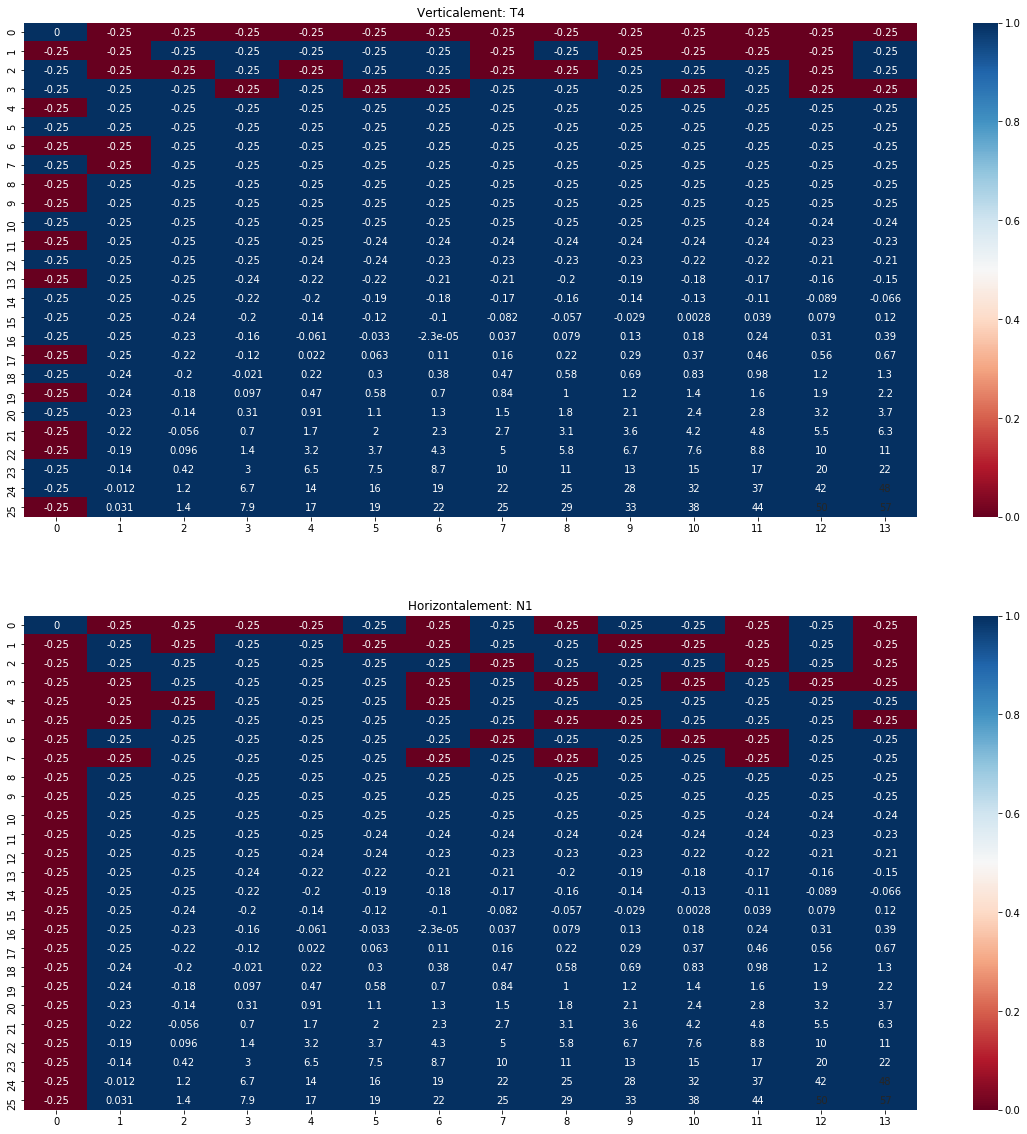

In [11]:
table_endo=pd.DataFrame((theta).reshape(14,26)).T
table_endonull=table_endo[table_endo==0]*-1

fig, axe=plt.subplots(2,1,figsize=(20,20), sharex=False)
sns.heatmap(table_endo,annot=True,cmap=None,cbar=None,ax=axe[0])
sns.heatmap(table_endo,annot=True,cmap=None,cbar=None,ax=axe[1])
sns.heatmap(heaviside(table_endo-lag_v(table_endo,1)),ax=axe[0],cmap="RdBu")
sns.heatmap(heaviside(table_endo-lag_h(table_endo,1)),ax=axe[1],cmap="RdBu")

axe[0].set_title("Verticalement: T4")
axe[1].set_title("Horizontalement: N1")

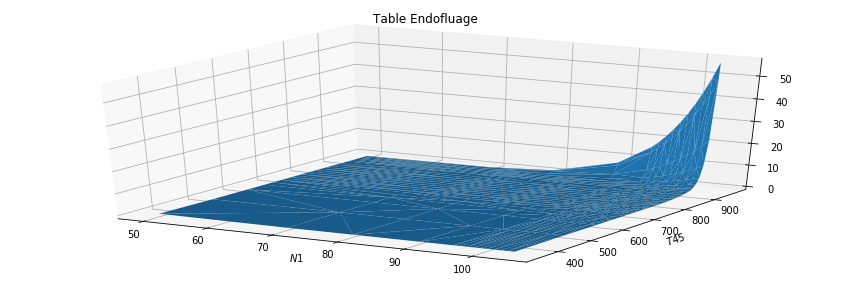

In [12]:
N1_liste=[50,70,80,90,95,96,97,98,99,100,101,102,103,104]
T45_liste=[350,500,600,650,675,700,715,730,745,760,775,790,805,820,835,850,865,880,900,910,920,930,940,950,960,962]
Y=[]
for N1 in N1_liste:
    for T45 in T45_liste:
        Y.append([N1,T45])
couple=pd.DataFrame(Y,columns=["N1","T45"])
couple1=couple.copy()
couple["result"]=pd.Series(theta)   
plot_surface(couple)